# Create a New Environment

In [ ]:
mamba create -n myjlabenv python=3.8 jupyterlab -c conda-forge
mamba activate myjlabenv
jupyter lab

# Install packages

In [4]:
!pip install pandas

# Read file

In [1]:
import pandas as pd
import re

# Define a function to parse each line of the log file
def parse_log_line(line):
    pattern = r'([^\s]+) - - \[(.*?)\] "(.*?)" (\d{3}) (\d+)$'
    match = re.search(pattern, line)
    if match:
        host = match.group(1)
        timestamp = match.group(2)
        filename = match.group(3).split()[1] if len(match.group(3).split()) > 1 else None  # To handle potential bad entries
        http_reply_code = match.group(4)
        bytes_sent = match.group(5)
        return host, timestamp, filename, http_reply_code, int(bytes_sent)
    else:
        return None, None, None, None, None

In [2]:
# Let's first read the contents of the uploaded file to understand its structure and format.
file_path = './datasets/calgary_HTTP'

In [3]:
# Try reading the file with ISO-8859-1 encoding which is more permissive than UTF-8
data = []
with open(file_path, 'r', encoding='ISO-8859-1') as file:
    for line in file:
        parsed_data = parse_log_line(line)
        if all(value is not None for value in parsed_data):  # Ensure no None values are added
            data.append(parsed_data)

# Convert the list to a DataFrame
columns = ['Host', 'Timestamp', 'Filename', 'HTTP_reply_code', 'Bytes']
df = pd.DataFrame(data, columns=columns)

# Convert timestamp to datetime object for easier manipulation
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%d/%b/%Y:%H:%M:%S %z', errors='coerce', utc=True)

# Display the first few rows of the new DataFrame
df.head()

,Host,Timestamp,Filename,HTTP_reply_code,Bytes
0,local,1994-10-24 19:41:41+00:00,index.html,200,150
1,local,1994-10-24 19:41:41+00:00,1.gif,200,1210
2,local,1994-10-24 19:43:13+00:00,index.html,200,3185
3,local,1994-10-24 19:43:14+00:00,2.gif,200,2555
4,local,1994-10-24 19:43:15+00:00,3.gif,200,36403


In [4]:
# Removing 'Host' and 'Filename' columns from the DataFrame
df = df.drop(['Host', 'Filename'], axis=1)

In [5]:
# Display the updated DataFrame without 'Host' and 'Filename'
df.head(20)

,Timestamp,HTTP_reply_code,Bytes
0,1994-10-24 19:41:41+00:00,200,150
1,1994-10-24 19:41:41+00:00,200,1210
2,1994-10-24 19:43:13+00:00,200,3185
3,1994-10-24 19:43:14+00:00,200,2555
4,1994-10-24 19:43:15+00:00,200,36403
5,1994-10-24 19:43:17+00:00,200,441
6,1994-10-24 19:46:45+00:00,200,3185
7,1994-10-24 19:46:45+00:00,200,2555
8,1994-10-24 19:46:47+00:00,200,36403
9,1994-10-24 19:46:50+00:00,200,441


# drop all of NA values

In [6]:
# Drop all NA values
df.dropna(inplace=True)

# Filter the dataset to only keep records from 1994-10-24
filtered_df = df[df['Timestamp'].dt.date == pd.to_datetime('1994-10-24').date()]

# Display the resulting DataFrame
filtered_df.head()

,Timestamp,HTTP_reply_code,Bytes
0,1994-10-24 19:41:41+00:00,200,150
1,1994-10-24 19:41:41+00:00,200,1210
2,1994-10-24 19:43:13+00:00,200,3185
3,1994-10-24 19:43:14+00:00,200,2555
4,1994-10-24 19:43:15+00:00,200,36403


In [36]:
csv_file_path = './datasets/filtered_calgary_HTTP.csv'

# Write the filtered_calgary_HTTP to a CSV file
filtered_df.to_csv(csv_file_path)

print("filtered_calgary_HTTP saved to:", csv_file_path)

filtered_calgary_HTTP saved to: ./datasets/filtered_calgary_HTTP.csv


# Check for Stationarity
https://www.analyticsvidhya.com/blog/2021/08/vector-autoregressive-model-in-python/
https://gist.github.com/kevincdurand1/e8307dfb3e370ca15bdbb97300037c71

In [14]:
!pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 18.6 MB/s eta 0:00:00m eta 0:00:010:00:01


In [15]:
from statsmodels.tsa.stattools import adfuller

In [16]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    for key,val in result[4].items():
        out[f'critical value ({key})']=val
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [17]:
adf_test(filtered_df['HTTP_reply_code'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -9.961431e+00
p-value                 2.367901e-17
# lags used             3.000000e+00
# observations          4.570000e+02
critical value (1%)    -3.444740e+00
critical value (5%)    -2.867885e+00
critical value (10%)   -2.570150e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [18]:
adf_test(filtered_df['Bytes'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -3.762756
p-value                   0.003312
# lags used              11.000000
# observations          449.000000
critical value (1%)      -3.444998
critical value (5%)      -2.867999
critical value (10%)     -2.570210
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


# line chart

In [11]:
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.5/159.5 kB 2.6 MB/s eta 0:00:00 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 15.2 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.2/309.2 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 18.9 MB/s eta 0:00:00m eta 0:00:010:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 14.8 MB/s eta 0:00:0031m17.7 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 15.8 MB/s eta 0:00:00 MB/s eta 0:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 8.9 MB/s eta 0:00:00


/tmp/ipykernel_14517/1053960319.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['HTTP_reply_code'] = filtered_df['HTTP_reply_code'].astype(int)


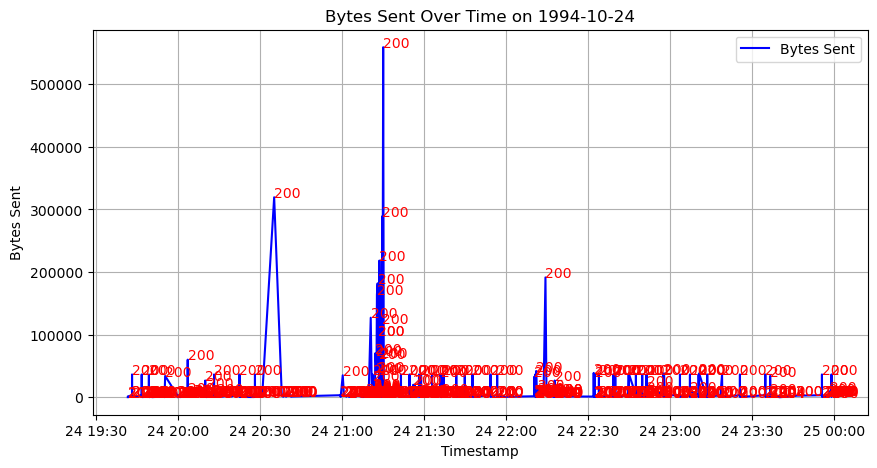

In [19]:
import matplotlib.pyplot as plt

# Converting 'HTTP_reply_code' to integer for plotting
filtered_df['HTTP_reply_code'] = filtered_df['HTTP_reply_code'].astype(int)

# Plotting the line chart
plt.figure(figsize=(10, 5))
plt.plot(filtered_df['Timestamp'], filtered_df['Bytes'], label='Bytes Sent', color='blue')
plt.title('Bytes Sent Over Time on 1994-10-24')
plt.xlabel('Timestamp')
plt.ylabel('Bytes Sent')
plt.grid(True)

# Adding HTTP reply codes as text labels to the plot for better clarity
for idx, row in filtered_df.iterrows():
    plt.text(row['Timestamp'], row['Bytes'], str(row['HTTP_reply_code']), color='red')

plt.legend()
plt.show()


# Train-Test Split

In [20]:
test_obs = 12
train = filtered_df[:-test_obs]
test = filtered_df[-test_obs:]

# Vector AutoRegressive Model (VAR)

## Grid Search for Order P

In [21]:
from statsmodels.tsa.vector_ar.var_model import VAR
import numpy as np

# Define the range of lag orders to test
max_lags = 15
results_aic = []

# Fit VAR model for each lag order and store the AIC
for p in range(1, max_lags + 1):
    model = VAR(train[['Bytes', 'HTTP_reply_code']])
    result = model.fit(maxlags=p)
    results_aic.append((p, result.aic))

# Find the order p with the lowest AIC
best_p = sorted(results_aic, key=lambda x: x[1])[0]

best_p, results_aic

((2, 25.32996956384271),
 [(1, 25.491057429537808),
  (2, 25.32996956384271),
  (3, 25.334787940413957),
  (4, 25.33939006446994),
  (5, 25.354081847631537),
  (6, 25.37401196003988),
  (7, 25.37254328178693),
  (8, 25.39434072421063),
  (9, 25.414533549755443),
  (10, 25.43710461602228),
  (11, 25.451880608713413),
  (12, 25.456106239792742),
  (13, 25.478398964051596),
  (14, 25.500092797716498),
  (15, 25.520377095879496)])

## Fit VAR(2) Model

In [22]:
result = model.fit(2)
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 30, Apr, 2024
Time:                     02:39:52
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    25.4217
Nobs:                     447.000    HQIC:                   25.3662
Log likelihood:          -6919.78    FPE:                1.00154e+11
AIC:                      25.3300    Det(Omega_mle):     9.79501e+10
--------------------------------------------------------------------
Results for equation Bytes
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                  37043.392609     61747.033034            0.600           0.549
L1.Bytes                   0.063320         0.045990            1.377           0.169
L1.HTTP_reply_code       -67.387914     

## Predict Test Data

In [23]:
# Forecasting 12 steps ahead which corresponds to the length of the test set
lag_order = result.k_ar
forecast_input = train[['Bytes', 'HTTP_reply_code']].values[-lag_order:]
forecast = result.forecast(y=forecast_input, steps=len(test))

# Creating a DataFrame for the forecasted values
forecast_df = pd.DataFrame(forecast, index=test.index, columns=['Bytes_forecast', 'HTTP_reply_code_forecast'])

# Combining the forecasted values with the actual test data for comparison
test_forecasted = pd.concat([test, forecast_df], axis=1)
test_forecasted


,Timestamp,HTTP_reply_code,Bytes,Bytes_forecast,HTTP_reply_code_forecast
449,1994-10-24 23:57:41+00:00,200,1161,9490.671995,200.445012
450,1994-10-24 23:57:46+00:00,200,2904,9427.762991,200.403082
451,1994-10-24 23:58:03+00:00,200,709,11607.471603,200.605558
452,1994-10-24 23:58:06+00:00,200,6627,11718.907068,200.584082
453,1994-10-24 23:58:13+00:00,200,2323,12269.025271,200.664496
454,1994-10-24 23:58:18+00:00,200,9585,12328.503639,200.656177
455,1994-10-24 23:58:54+00:00,200,3185,12467.337411,200.686045
456,1994-10-24 23:58:54+00:00,200,2555,12489.927509,200.683151
457,1994-10-24 23:58:55+00:00,200,36403,12524.784435,200.693823
458,1994-10-24 23:58:56+00:00,200,441,12532.258075,200.692866


## Plot the Result

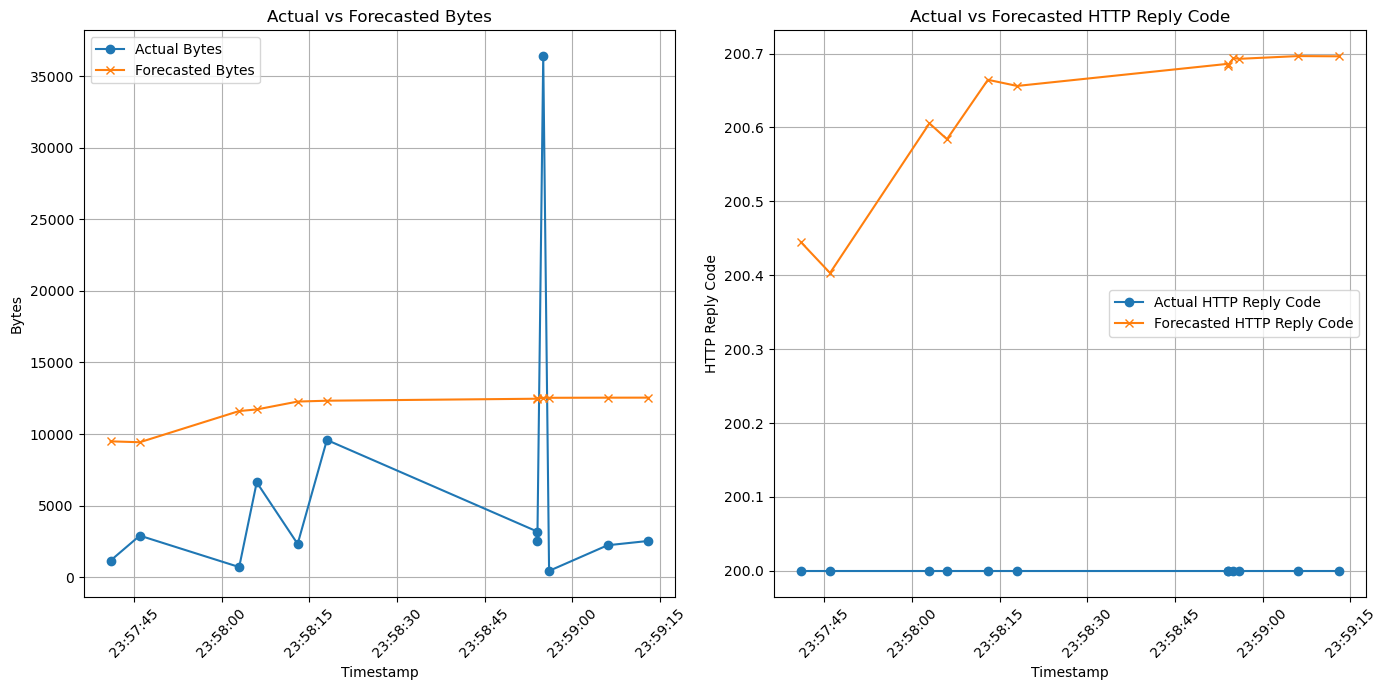

In [24]:
# Plotting the actual vs forecasted values for 'Bytes' and 'HTTP_reply_code'
plt.figure(figsize=(14, 7))

# Plot for 'Bytes'
plt.subplot(1, 2, 1)
plt.plot(test['Timestamp'], test['Bytes'], label='Actual Bytes', marker='o')
plt.plot(test['Timestamp'], forecast_df['Bytes_forecast'], label='Forecasted Bytes', marker='x')
plt.title('Actual vs Forecasted Bytes')
plt.xlabel('Timestamp')
plt.ylabel('Bytes')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# Plot for 'HTTP_reply_code'
plt.subplot(1, 2, 2)
plt.plot(test['Timestamp'], test['HTTP_reply_code'], label='Actual HTTP Reply Code', marker='o')
plt.plot(test['Timestamp'], forecast_df['HTTP_reply_code_forecast'], label='Forecasted HTTP Reply Code', marker='x')
plt.title('Actual vs Forecasted HTTP Reply Code')
plt.xlabel('Timestamp')
plt.ylabel('HTTP Reply Code')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## mean absolute error

In [42]:
def mean_absolute_error(actual, predicted):
    return sum(abs(a - p) for a, p in zip(actual, predicted)) / len(actual)

In [26]:
mae = mean_absolute_error(test_forecasted["Bytes"], test_forecasted["Bytes_forecast"])
print("Mean Absolute Error:", mae)

Mean Absolute Error: 9919.930255069527


# RRP

In [32]:
filtered_df

,Timestamp,HTTP_reply_code,Bytes
0,1994-10-24 19:41:41+00:00,200,150
1,1994-10-24 19:41:41+00:00,200,1210
2,1994-10-24 19:43:13+00:00,200,3185
3,1994-10-24 19:43:14+00:00,200,2555
4,1994-10-24 19:43:15+00:00,200,36403
...,...,...,...
456,1994-10-24 23:58:54+00:00,200,2555
457,1994-10-24 23:58:55+00:00,200,36403
458,1994-10-24 23:58:56+00:00,200,441
459,1994-10-24 23:59:06+00:00,200,2231


## SWAY

In [8]:
import random
import numpy as np
import math
import os
import pandas as pd
import time

class random_projection:
    def __init__(self, data, stop_depth):
        self.data = data.to_numpy()
        self.stop_depth = stop_depth
        self.res = self.cluster(self.data, self.stop_depth, [])
        #print (self.res)
        self.NumOfCluster = self.setNumOfCluster()
        #print (self.NumOfCluster)
        self.labels = np.ones(data.shape[0])
        self.setLabels()
        #print("Array of ones:", self.labels)

    def setLabels(self):
        for m in range(self.NumOfCluster):
            #print(m)
            for n in range(len(self.res[m])):
                row = self.getMatchedRowsIndices(self.res[m][n], self.data)
                #print (row)
                self.labels[row] = m
                
    def getLabels(self):
        return self.labels
        
    def getNumOfCluster(self):
        return self.NumOfCluster
        
    def setNumOfCluster(self):
        return len(self.res)
        
    @staticmethod    
    def getMatchedRowsIndices(target_row, array):
        # Make sure the target row has the right shape
        if target_row.shape[0] != array.shape[1]:
            print("The target row does not have the same number of elements as the array rows.")
        else:
            # Compare each row in the array with the target row
            matches = np.all(array == target_row, axis=1)
    
            # Use np.where to find the indices of matches
            row_indices = np.where(matches)[0]
    
            return row_indices
            
    def cluster(self, candidates, enough, res):
        if len(candidates) < enough:
            res.append(candidates)
            return res
    
        east, west, east_items, west_items = self.split(candidates)
        res = self.cluster(east_items, enough, res)
        res = self.cluster(west_items, enough, res)
    
        return res


    def split(self, candidates):
        pivot = random.choice(candidates)
        east_pivot = self.find_farest(pivot, candidates)
        west_pivot = self.find_farest(east_pivot, candidates)
        c = self.cal_distance(east_pivot, west_pivot)
    
        if c == 0:
            east_items = candidates[:len(candidates)//2]
            west_items = candidates[len(candidates)//2:]
            return east_pivot, west_pivot, east_items, west_items
    
        all_distance = []
        for candidate in candidates:
            a = self.cal_distance(candidate, west_pivot)
            b = self.cal_distance(candidate, east_pivot)
            d = (a ** 2 + c ** 2 - b ** 2) / (2 * c)
            all_distance.append((d, candidate))
    
        all_distance.sort(key=lambda x: x[0])
        sorted_candidates = [item[1] for item in all_distance]
        east_items = sorted_candidates[:len(sorted_candidates)//2]
        west_items = sorted_candidates[len(sorted_candidates)//2:]
    
        return east_pivot, west_pivot, east_items, west_items
    
    @staticmethod
    def find_farest(pivot, candidates):
        max_d = 0
        most_point = pivot
    
        for candidate in candidates:
            cur_d = random_projection.cal_distance(pivot, candidate)
            if  cur_d > max_d:
                max_d = cur_d
                most_point = candidate
        
        return most_point
    
    @staticmethod
    def cal_distance(p1, p2):
        return math.sqrt(sum([(v1 - v2) ** 2 for v1, v2 in zip(p1[:-1], p2[:-1])]))



In [9]:
def add_labels_to_df(df, labels_data, labels_name):
    if len(labels_data) == len(df):
        # Adding the new column
        df[labels_name] = labels_data
    else:
        print("The length of the ndarray does not match the number of DataFrame rows.")

    # Convert 'my_column' to int
    df[labels_name] = df[labels_name].astype(int)


In [10]:
  # Let's assume we have data for sales in a week across three departments
data = {
    'Electronics': [2350, 3200, 1530, 2050, 2980, 4200, 3700],
    'Clothing': [1500, 1700, 900, 1200, 2100, 2600, 1800],
    'Groceries': [5400, 6200, 5900, 5100, 6200, 6800, 7100]
}

# Create DataFrame
df = pd.DataFrame(data)
df

,Electronics,Clothing,Groceries
0,2350,1500,5400
1,3200,1700,6200
2,1530,900,5900
3,2050,1200,5100
4,2980,2100,6200
5,4200,2600,6800
6,3700,1800,7100


In [11]:
test = random_projection(df, 7)
df_labels = test.getLabels()
add_labels_to_df(df, df_labels, 'df_labels')

In [12]:
df

,Electronics,Clothing,Groceries,df_labels
0,2350,1500,5400,1
1,3200,1700,6200,1
2,1530,900,5900,1
3,2050,1200,5100,1
4,2980,2100,6200,0
5,4200,2600,6800,0
6,3700,1800,7100,0


## RandomProjectionRegression

In [29]:
import random
import numpy as np
import math
import pandas as pd

class RandomProjectionRegression:
    def __init__(self, data, stop_depth, target_index):
        self.data = data
        self.stop_depth = stop_depth
        self.target_index = target_index
        self.tree = self.build_tree(self.data.to_numpy(), self.stop_depth)

    def build_tree(self, candidates, enough):
        # Ensure candidates is always a numpy array
        candidates = np.array(candidates) if not isinstance(candidates, np.ndarray) else candidates

        if len(candidates) <= enough:
            # Calculate the median if there are any candidates
            median_value = np.median(candidates[:, self.target_index]) if candidates.size > 0 else None
            return {"type": "leaf", "median": median_value}
    
        east_pivot, west_pivot, east_items, west_items = self.split(candidates)
        return {
            "type": "node",
            "east_pivot": east_pivot,
            "west_pivot": west_pivot,
            "east_child": self.build_tree(east_items, enough),
            "west_child": self.build_tree(west_items, enough)
        }

    def split(self, candidates):
        pivot = random.choice(candidates)
        east_pivot = self.find_farest(pivot, candidates)
        west_pivot = self.find_farest(east_pivot, candidates)
        c = self.cal_distance(east_pivot, west_pivot)

        if c == 0:
            mid_point = len(candidates) // 2
            return east_pivot, west_pivot, candidates[:mid_point], candidates[mid_point:]

        # Compute distances and handle None values by assigning a large number
        all_distance = [(self.cal_projection_dist(candidate, west_pivot, east_pivot, c) or float('inf'), candidate) for candidate in candidates]

        # Sort based on the first element of each tuple, handling None values
        all_distance.sort(key=lambda x: x[0] if x[0] is not None else float('inf'))

        mid_point = len(all_distance) // 2
        east_items = [item[1] for item in all_distance[:mid_point]]
        west_items = [item[1] for item in all_distance[mid_point:]]
        return east_pivot, west_pivot, east_items, west_items

    def predict(self):
        predictions = []
        for index, row in self.data.iterrows():
            predictions.append(self.localize_and_predict(row.to_numpy(), self.tree))
        return predictions

    def localize_and_predict(self, data_point, node):
        if node["type"] == "leaf":
            return node["median"]
        if self.cal_distance(data_point, node["east_pivot"]) < self.cal_distance(data_point, node["west_pivot"]):
            return self.localize_and_predict(data_point, node["east_child"])
        else:
            return self.localize_and_predict(data_point, node["west_child"])

    @staticmethod
    def find_farest(pivot, candidates):
        max_distance = 0
        farest_point = pivot
        for candidate in candidates:
            distance = RandomProjectionRegression.cal_distance(pivot, candidate)
            if distance > max_distance:
                max_distance = distance
                farest_point = candidate
        return farest_point

    @staticmethod
    def cal_distance(p1, p2):
        return math.sqrt(sum((v1 - v2) ** 2 for v1, v2 in zip(p1, p2)))

    @staticmethod
    def cal_projection_dist(candidate, west_pivot, east_pivot, c):
        a = RandomProjectionRegression.cal_distance(candidate, west_pivot)
        b = RandomProjectionRegression.cal_distance(candidate, east_pivot)

In [30]:
# Example Usage:
data = {
    'Electronics': [2350, 3200, 1530, 2050, 2980, 4200, 3700],
    'Clothing': [1500, 1700, 900, 1200, 2100, 2600, 1800],
    'Groceries': [5400, 6200, 5900, 5100, 6200, 6800, 7100],
    'Sales': [200, 300, 150, 250, 280, 350, 310]
}
df = pd.DataFrame(data)

In [50]:
temp = filtered_df
temp = temp.drop('Timestamp', axis=1)
temp = temp.apply(pd.to_numeric, errors='coerce')
temp

,HTTP_reply_code,Bytes
0,200,150
1,200,1210
2,200,3185
3,200,2555
4,200,36403
...,...,...
456,200,2555
457,200,36403
458,200,441
459,200,2231


In [51]:
# Assuming your class and all necessary imports are already defined and the class code is correctly implemented

# Initialize the RandomProjectionRegression class
# Let's say we decide to stop splitting when a cluster size is less than 3,
# and the target variable ('Sales') is at index -1 (the last column of the DataFrame)
regression_model = RandomProjectionRegression(temp, stop_depth=800, target_index=-1)

# Generate predictions for each row in the DataFrame
# This will walk each data point down the tree to its relevant leaf and return the median of that leaf
predictions = regression_model.predict()

# Add the predictions as a new column to the DataFrame to compare or analyze
temp['predicted'] = predictions

# Show the updated DataFrame
print(temp)


     HTTP_reply_code  Bytes  predicted
0                200    150     2555.0
1                200   1210     2555.0
2                200   3185     2555.0
3                200   2555     2555.0
4                200  36403     2555.0
..               ...    ...        ...
456              200   2555     2555.0
457              200  36403     2555.0
458              200    441     2555.0
459              200   2231     2555.0
460              200   2534     2555.0

[461 rows x 3 columns]


In [52]:
mae = mean_absolute_error(temp["Bytes"], temp["predicted"])
print("Mean Absolute Error:", mae)

Mean Absolute Error: 11127.49240780911


# Explainable Boosted Linear Regression (EBLR)

In [43]:
!mamba install -y sklearn


Looking for: ['sklearn']

error    libmamba Could not open lockfile '/opt/mambaforge/pkgs/cache/cache.lock'
error    libmamba Could not open lockfile '/opt/mambaforge/pkgs/cache/cache.lock'
[+] 0.0s
[+] 0.1s
conda-forge/linux-64 ━━━━━━━━━━━━━╸━━━━━━━━━   0.0 B /  ??.?MB @  ??.?MB/s  0.1s
conda-forge/noarch   ━━━━━━━━╸━━━━━━━━━━━━━━   0.0 B /  ??.?MB @  ??.?MB/s  0.1s[+] 0.2s
conda-forge/linux-64 ━━━━━━━━━━━━━━━━━━━━━━   0.0 B @  ??.?MB/s Downloaded  0.2s
conda-forge/noarch   ━━━━━━━━━━╸━━━━━━━━━━━   0.0 B @  ??.?MB/s             0.2sconda-forge/linux-64                                          No change
conda-forge/noarch                                            No change

Pinned packages:
  - python 3.8.*


Could not solve for environment specs
The following package could not be installed
└─ sklearn does not exist (perhaps a typo or a missing channel).


In [37]:
# Prepare features and target variable
X = filtered_df.drop(columns=['Bytes', 'Timestamp'])  # Features excluding the target and original timestamp
y = filtered_df['Bytes']  # Target variable

In [39]:
from sklearn.model_selection import train_test_split
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize and fit the Gradient Boosting Regressor
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)

# Predictions
y_pred_train = gbr.predict(X_train)
y_pred_test = gbr.predict(X_test)

# Calculate performance metrics
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

train_mse, test_mse, train_r2, test_r2

# Multioutput Regression SVM
https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-perform-multioutput-regression-with-svms-in-python.md

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Create a pipeline with a scaler and an SVR model
svm_pipeline = make_pipeline(StandardScaler(), SVR())

# Fit the model
svm_pipeline.fit(X_train, y_train)

# Evaluate the model

# Predict on the testing set
y_pred = svm_pipeline.predict(X_test)

# Calculate the Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
mae


# Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Create a Random Forest Regressor pipeline with scaling
rf_pipeline = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=42))

# Fit the Random Forest model
rf_pipeline.fit(X_train, y_train)

# Predict on the testing set
y_pred_rf = rf_pipeline.predict(X_test)

# Calculate the Mean Absolute Error for Random Forest
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mae_rf


# Gradient Boosting Machines (GBM)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

# Create a Gradient Boosting Regressor pipeline with scaling
gbm_pipeline = make_pipeline(StandardScaler(), GradientBoostingRegressor(random_state=42))

# Fit the GBM model
gbm_pipeline.fit(X_train, y_train)

# Predict on the testing set
y_pred_gbm = gbm_pipeline.predict(X_test)

# Calculate the Mean Absolute Error for GBM
mae_gbm = mean_absolute_error(y_test, y_pred_gbm)
mae_gbm


# Large Bayesian vector auto regressions (BVARs)

##  Install PyMC3

sudo pacman -S libxcrypt
Create a Symlink for crypt.h 
sudo find / -name 'crypt.h'
sudo ln -s /usr/include/crypt.h /home/yanboyang713/.conda/envs/workload/include/python3.8/crypt.h


In [2]:
!mamba install -y pymc3 -c conda-forge


Looking for: ['pymc3']

error    libmamba Could not open lockfile '/opt/mambaforge/pkgs/cache/cache.lock'
conda-forge/linux-64                                        Using cache
error    libmamba Could not open lockfile '/opt/mambaforge/pkgs/cache/cache.lock'
conda-forge/noarch                                          Using cache

Pinned packages:
  - python 3.8.*


Transaction

  Prefix: /home/yanboyang713/.conda/envs/workload

  Updating specs:

   - pymc3
   - ca-certificates
   - certifi
   - openssl


  Package                          Version  Build                   Channel           Size
────────────────────────────────────────────────────────────────────────────────────────────
  Install:
────────────────────────────────────────────────────────────────────────────────────────────

  + wrapt                           1.16.0  py38h01eb140_0          conda-forge       55kB
  + libgcc-devel_linux-64            9.5.0  h0a57e50_19             conda-forge        4MB
  + libsanitizer

In [29]:
import pymc3 as pm
import numpy as np
print(pymc3.__version__)

3.11.5


In [34]:
# Assuming 'train' is your DataFrame containing the training data
data_bvar = train[['Bytes', 'HTTP_reply_code']]

with pm.Model() as bvar_model:
    # Priors for unknown model parameters
    coefs = pm.Normal('coefs', mu=0, sigma=10, shape=(2, 2))  # Shape corresponds to (number of variables, lag order)
    
    # Error terms with a prior on sigma
    sigma = pm.HalfCauchy('sigma', beta=5, shape=2)
    
    # Constructing the lagged data matrices
    X1 = data_bvar.shift(1).fillna(0).values
    X2 = data_bvar.shift(2).fillna(0).values
    
    # Ensure matrices are 2-dimensional
    if X1.ndim != 2 or X2.ndim != 2:
        raise ValueError(f"Dimension mismatch: X1 dim={X1.ndim}, X2 dim={X2.ndim}")
    
    # Constructing the mean
    mu = pm.math.dot(X1, coefs[0]) + pm.math.dot(X2, coefs[1])
    
    # Defining the covariance matrix
    cov_matrix = pm.math.diag_matrix(sigma)  # Create a diagonal covariance matrix
    
    # Model likelihood using a Multivariate Normal
    likelihood = pm.MvNormal('likelihood', mu=mu, cov=cov_matrix, observed=data_bvar.values)

# Fitting the model
with bvar_model:
    trace = pm.sample(1000, tune=500, return_inferencedata=False)

# Summarizing the posterior
summary = pm.summary(trace).round(2)


AttributeError: module 'pymc3.math' has no attribute 'diag_matrix'